## GCCA implementation from the fMRI paper

In [181]:
import numpy as np
from scipy import linalg,stats
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize

from tqdm import tqdm

from src.features.gcca import gcca

import graspy
from graspy.plot import pairplot
%matplotlib inline
import matplotlib.pyplot as plt

In [173]:
def _preprocess(x):
    """
    Subtracts the row means and divides by the standard deviation.
    Then subtracts column means.
    
    Parameters
    ----------
    x : array-like, shape (n_regions, n_features)
        The data to preprocess
    """
    
    # Mean along rows using sample mean and sample std
    x2 = stats.zscore(x,axis=1,ddof=1) 
    # Mean along columns
    mu = np.mean(x2,axis=0)
    x2 -= mu
    return(x2)

def gCCA(data, rank_ratio=0.9, n_components=3, n_embed=3):
    n_subj = len(data)
    n = data[0].shape[0]

    data = [_preprocess(x) for x in data]
    
    Uall = []
    Sall = []
    Vall = []
    ranks = []
    Dinv = []
    C = []
    
    X = []
    
    for y in tqdm(data):
        # Preprocess
        y[np.isnan(y)] = 0

        # compute the SVD of the data
        u,s,vt = linalg.svd(y, full_matrices=False)
        ut = u.T; v = vt.T
        
        Sall.append(s)
        Vall.append(v)
        # Dimensions to reduce to
        if n_components:
            rank = n_components
        else:
            s2 = np.square(s)
            rank = sum(np.cumsum(s2/sum(s2)) < rank_ratio) + 1
        ranks.append(rank)
        
        vr = v[:,:rank]
        x = y @ vr
        
        X.append(x)
                
    for r in range(n_subj):
        temp = []
        for c in range(n_subj):
            if r >= c:
                temp.append(np.zeros((n,n)))
            else:
                temp.append(X[c] @ X[r].T)
            if r == c:
                _,S,Wt = linalg.svd(X[r].T, full_matrices=False)
                S = np.diag(S)
                Dinv.append(Wt.T @ S @ S @ Wt)
        C.append(temp)
    
    Dinv = linalg.block_diag(*Dinv)
    C = np.block(C)
    
    _,S,Wt = svds(1/(n_subj-1) * Dinv @ C, n_embed)
    
    ranks = [0] + ranks
    return([X[i] @ Wt.T[ranks[i]:ranks[i] + ranks[i+1],:] for i in range(n_subj)])

In [183]:
X = np.random.normal(0,1,size=(20,5))
Y = np.random.normal(10,1,size=(20,5))

In [187]:
projs = gCCA((X,Y), n_components=3, n_embed=6)

100%|██████████| 2/2 [00:00<00:00, 825.73it/s]


In [189]:
projs2 = gcca((X,Y), n_components=3)

100%|██████████| 2/2 [00:00<00:00, 1353.22it/s]


array([[ 0.        ,  0.        ,  0.        ,  0.00303122, -0.55274975,
         0.10401446],
       [ 0.        ,  0.        ,  0.        , -0.45324392,  0.16581057,
         0.49050579],
       [ 0.        ,  0.        ,  0.        ,  0.12071322,  0.93384483,
         0.10714747],
       [ 0.        ,  0.        ,  0.        ,  0.50292424,  0.11544293,
        -0.58031415],
       [ 0.        ,  0.        ,  0.        ,  0.31024696,  0.42648484,
        -0.25191378],
       [ 0.        ,  0.        ,  0.        , -0.02507056, -0.58989992,
        -0.07649315],
       [ 0.        ,  0.        ,  0.        ,  0.16872586,  0.18578253,
        -0.03386666],
       [ 0.        ,  0.        ,  0.        ,  0.18920706, -0.53328828,
        -0.50325176],
       [ 0.        ,  0.        ,  0.        , -0.47120588,  0.21457531,
         0.45147414],
       [ 0.        ,  0.        ,  0.        , -0.28939636,  0.66651716,
         0.31693288],
       [ 0.        ,  0.        ,  0.        , -0.

LinAlgError: singular matrix

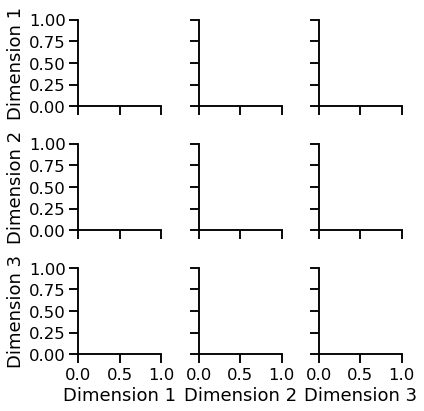

In [178]:
pairplot(np.vstack(projs), labels=[0] * 20 + [1] * 20, height=2)